In [1]:
import random

points = range(12, 22) # Возможные очки от 12 до 21
dealer_card = [2, 3, 4, 5, 6, 7, 8, 9, 10, None] # Открытая карта диллера, Играющий туз - 10-й вариант
playing_ace = [0, 1] # Наличие играющего туза
states = [[i,j,k] for i in points for j in dealer_card  for k in playing_ace] # возможные состояния
random.seed(555)

In [2]:
def get_card(cards, player_cards):
    i = random.randrange(len(cards))
    card = cards[i]
    del cards[i]
    if card is None:
        if sum(player_cards) == 11:
            card = 1
        else:
            card = 11
    player_cards.append(card)

In [3]:
def run_episode():
    # S Состояние - строка 'сумма очков/открытая карта сдающего/наличие играющего туза'
    # А - действие 1 - еще, 0 - хватит
    # R - вознагражение - на всех шагах кроме последнего 0, 1 если выигрыш, 0 если ничья, -1 если проигрыш
    episode = []


    cards = [2, 3, 4, 5, 6, 7, 8, 9, 10,
             None, # Туз
             10,   # Валет
             10,   # Дама
             10]   # Король
    #колода
    cards = cards*4
    random.shuffle(cards)
    dealer_cards, player_cards, cards = cards[:2], cards[2:4], cards[4:]
    dealer_open_card = random.choice(dealer_cards)
    if_has_play_ace = 0

    # В начале партии разбираемся с играющими тузами
    if (dealer_cards[0] is None) and (dealer_cards[1] is None):
        dealer_cards[0] = 11
        dealer_cards[1] = 1
    else:
        if dealer_cards[0] is None:
            dealer_cards[0] = 11
        if dealer_cards[1] is None:
            dealer_cards[1] = 11

    if (player_cards[0] is None) and (player_cards[1] is None):
        player_cards[0] = 11
        player_cards[1] = 1
        if_has_play_ace = 1
    else:
        if player_cards[0] is None:
            player_cards[0] = 11
            if_has_play_ace = 1
        if player_cards[1] is None:
            player_cards[1] = 11
            if_has_play_ace = 1

    # Набираем до 12 так как счет суммы очков имеет смысл вести с 12
    while True:
        if sum(player_cards)>=12:
            break
        get_card(cards, player_cards)

    A = 1 # Текущее действие игрока
    R = 0 # Выигрыш всегда на каждом шаге 0 (кроме последнего)

    d_sum = sum(dealer_cards)
    p_sum = sum(player_cards)

    while True:
        if A == 1:
            # Добавляем ход в эпизод (игру)
            S = '|'.join([str(p_sum), str(dealer_open_card), str(if_has_play_ace)])
            episode.append([S,A,R])

        if A == 1:
            if ((d_sum == 21) and (p_sum == 21)):
                break
            if (d_sum == 21):
                episode[-1][2] = -1
                break
        elif A == 0:
            if (d_sum >= 17):
                if (d_sum > p_sum):
                    episode[-1][2] = -1
                    break
                if (d_sum < p_sum):
                    episode[-1][2] = 1
                    break
                if (d_sum == p_sum):
                    break
            else:
                if (d_sum > p_sum):
                    episode[-1][2] = -1
                    break

        # Ход игрока стратегия хватит или дальше
        if A == 1:
            A = random.choice([0, 1])

        if A == 1:
            get_card(cards, player_cards)
            p_sum = sum(player_cards)
            if p_sum > 21:
                episode[-1][2] = -1
                break

        if A == 0:
            get_card(cards, dealer_cards)  
            d_sum = sum(dealer_cards)
            if d_sum > 21:
                episode[-1][2] = 1
                break
    
    return episode

In [4]:
episodes = []
N = 500000

In [5]:
for i in range(N):
    episodes.append(run_episode())

In [6]:
# Итоговые стратегии для состояний
strategies = {}
# Заполняем начальные стратегии
for points in range(12, 22):
    for open_card in [2, 3, 4, 5, 6, 7, 8, 9, 10, None]:
        for playing_ace in [0, 1]:
            S = '|'.join([str(points), str(open_card), str(playing_ace)])
            if points in (20, 21):
                strategies[S] = 0
            else:
                strategies[S] = 1

In [7]:
# Функции ценностей и Returns для всех пар состояние-действие
values, rets = {}, {}
# Заполняем начальные ценности и Returns
for points in range(12, 22):
    for open_card in [2, 3, 4, 5, 6, 7, 8, 9, 10, None]:
        for playing_ace in [0, 1]:
            S = '|'.join([str(points), str(open_card), str(playing_ace)])
            for action in [0, 1]:
                key = '|'.join([S, str(action)])
                values[key] = 0.0
                rets[key] = []

In [8]:
def avg_lst(lst):
    return sum(lst) / float(len(lst))

In [9]:
for episode in episodes:
    # МК метод первого посещения
    visited = []
    for step in episode:
        visited_key = ''.join([step[0], str(step[1]), str(step[2])])
        if visited_key in visited:
            continue
        visited.append(visited_key)
        key = '|'.join([step[0], str(step[1])])
        rets[key].append(step[2])
        values[key] = avg_lst(rets[key])
        
        # Выбор оптимальной стратегии
        sk1, sk0 = '|'.join([step[0],str(1)]), '|'.join([step[0],str(0)])
        
        if values[sk1] > values[sk0]:
            strategies[step[0]] = 1
        else:
            strategies[step[0]] = 0

In [10]:
strategies_ace_points = []
strategies_ace_dealer_card = []
strategies_actions = []
for k in strategies.keys():
    if_ace = int(k[-1])
    ind = k.find('|')
    points = int(k[:ind])
    ind2 = k.find('|',(ind+1))
    dealer_card = k[(ind+1):ind2]
    if dealer_card == 'None':
        dealer_card = 11
    else:
        dealer_card = int(dealer_card)
    if (if_ace == 1):
        strategies_ace_points.append(points)
        strategies_ace_dealer_card.append(dealer_card)
        strategies_actions.append(strategies[k])

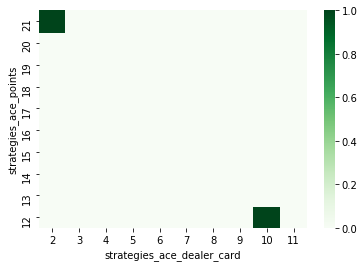

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data = pd.DataFrame(data={'strategies_ace_points':strategies_ace_points,
                          'strategies_ace_dealer_card':strategies_ace_dealer_card, 
                           'strategies_actions':strategies_actions})
data = data.pivot(columns='strategies_ace_dealer_card', index='strategies_ace_points', values='strategies_actions')
ax = sns.heatmap(data, cmap="Greens")
ax.invert_yaxis()